<a href="https://colab.research.google.com/github/goralex02/time-series-project/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Работа с временными рядами стоимости акций

Контрольное задание
1.	Найти три любых временных ряда, связанных между собой
Можно Составить портфель из 3 биржевых инструментов, сделать для них выборку биржевых данных за один месяц
2.	Выполнить статистический анализ данных Очистку данных, провести тестирование на стационарность, на коинтеграцию
3.	Выбрать в качестве основного один из рядов
4.	Построить  ARIMA  и ARMAX модель, вывести параметры, сравнить
5.	Построить две модели из семейства GARCH, вывести параметры, сравнить при разных p, q
6.	Построить VAR модель
7.	Построить 2  любых бустинговых модели (XGBoost, ThymeBoost, CatBoost)

Дополнительно:
8.	Построить модель на нейронных сетях

Примечание:  Работа должна содержать графики исходных сигналов и результатов моделирования


## 1.	Найти три любых временных ряда, связанных между собой
Можно Составить портфель из 3 биржевых инструментов, сделать для них выборку биржевых данных за один месяц

[*********************100%***********************]  3 of 3 completed


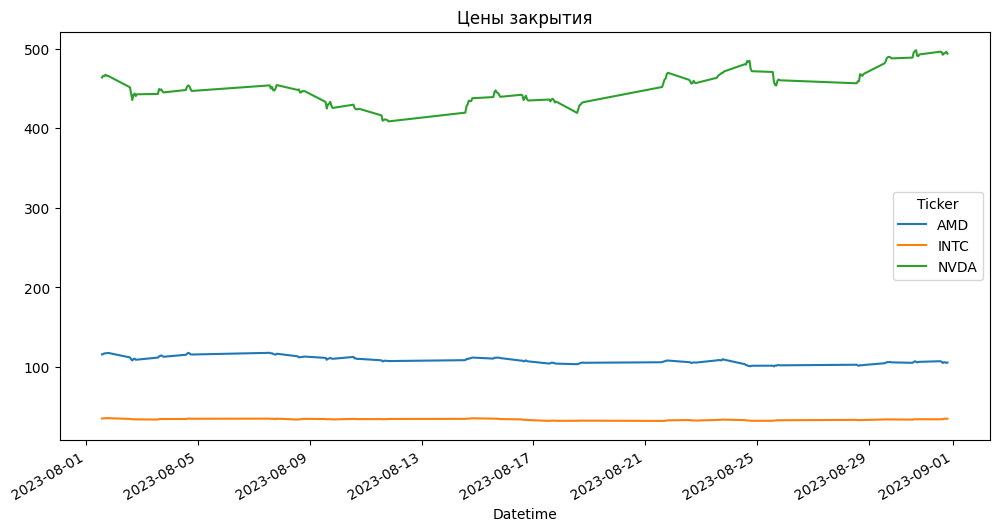

In [62]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
tickers = ['NVDA', 'AMD', 'INTC']
data = yf.download(tickers, start='2023-08-01', end='2023-09-01', interval='1h')['Close']

# Визуализация
data.plot(figsize=(12, 6))
plt.title('Цены закрытия')
plt.show()

In [59]:
# Проверим, есть ли даты, которые попадают на выходные
weekends = data.index[data.index.weekday >= 5]  # 5 = суббота, 6 = воскресенье
print(f"Количество записей в выходные: {len(weekends)}")
print(weekends)  # если хочешь увидеть сами даты

Количество записей в выходные: 0
DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Datetime', freq=None)


In [63]:
print(data.head())

Ticker                            AMD       INTC        NVDA
Datetime                                                    
2023-08-01 13:30:00+00:00  115.979897  35.459999  463.620087
2023-08-01 14:30:00+00:00  116.290001  35.639999  465.914093
2023-08-01 15:30:00+00:00  117.235001  35.820000  465.299988
2023-08-01 16:30:00+00:00  117.279999  35.775002  467.250000
2023-08-01 17:30:00+00:00  117.440002  35.869999  465.755005


In [64]:
print(data.tail())

Ticker                            AMD       INTC        NVDA
Datetime                                                    
2023-08-31 15:30:00+00:00  105.190002  34.529900  492.239990
2023-08-31 16:30:00+00:00  106.239899  35.154999  494.030212
2023-08-31 17:30:00+00:00  105.879997  35.285000  494.170013
2023-08-31 18:30:00+00:00  105.314499  35.145000  496.010010
2023-08-31 19:30:00+00:00  105.669998  35.150002  493.649994


## 2.	Выполнить статистический анализ данных Очистку данных, провести тестирование на стационарность, на коинтеграцию

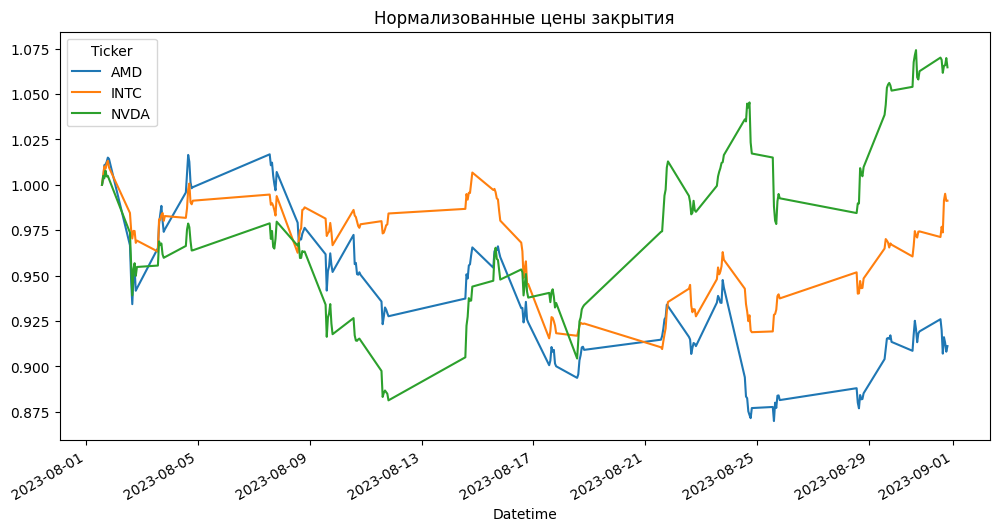

In [65]:
# Нормализация (приведение к одному масштабу, начало с 1)
normalized_data = data / data.iloc[0]
normalized_data.plot(figsize=(12, 6))
plt.title('Нормализованные цены закрытия')
plt.show()

In [66]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2023-08-01 13:30:00+00:00 to 2023-08-31 19:30:00+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMD     161 non-null    float64
 1   INTC    161 non-null    float64
 2   NVDA    161 non-null    float64
dtypes: float64(3)
memory usage: 5.0 KB
None


In [67]:
print(data.NVDA.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 161 entries, 2023-08-01 13:30:00+00:00 to 2023-08-31 19:30:00+00:00
Series name: NVDA
Non-Null Count  Dtype  
--------------  -----  
161 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB
None


In [68]:
print(data.isnull().sum())

Ticker
AMD     0
INTC    0
NVDA    0
dtype: int64


In [69]:
print(data.duplicated().sum())

0


In [70]:
print(data.describe())

Ticker         AMD        INTC        NVDA
count   161.000000  161.000000  161.000000
mean    108.787339   34.186695  452.446608
std       4.488584    0.958649   22.078484
min     100.879898   32.250000  408.549988
25%     105.610397   33.340000  435.369904
50%     108.220001   34.439999  449.181885
75%     111.742699   34.910000  465.914093
max     117.930000   35.930000  498.035004


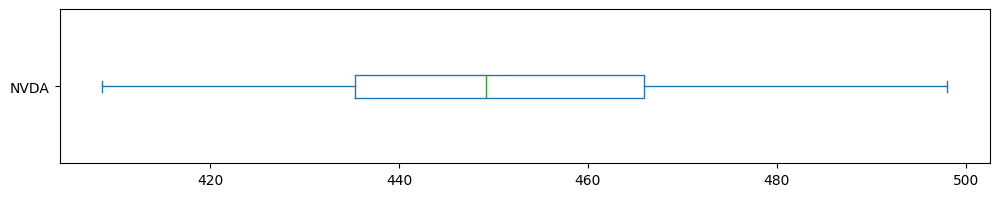

In [71]:
data.NVDA.plot.box(figsize=(12, 2), vert=False);

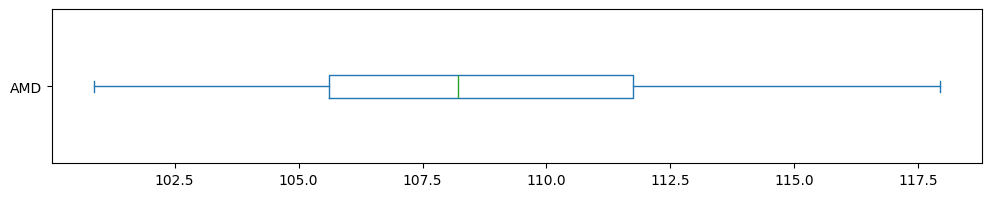

In [72]:
data.AMD.plot.box(figsize=(12, 2), vert=False);

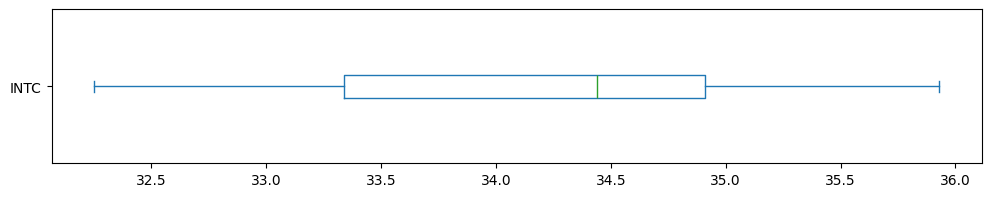

In [73]:
data.INTC.plot.box(figsize=(12, 2), vert=False);

In [74]:
# Корреляционная матрица
corr_matrix = data.corr()
print("Корреляция между рядами:")
print(corr_matrix)


Корреляция между рядами:
Ticker       AMD      INTC      NVDA
Ticker                              
AMD     1.000000  0.773503 -0.239029
INTC    0.773503  1.000000 -0.051289
NVDA   -0.239029 -0.051289  1.000000


In [75]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, name):
    result = adfuller(series)
    print(f"Тест Дики-Фуллера для {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Ряд стационарен.")
    else:
        print("Ряд нестационарен.")

for col in data.columns:
    test_stationarity(data[col], col)

Тест Дики-Фуллера для AMD:
ADF Statistic: -1.9754901200491748
p-value: 0.2974221325405673
Ряд нестационарен.
Тест Дики-Фуллера для INTC:
ADF Statistic: -1.8341645335028154
p-value: 0.36363666062353783
Ряд нестационарен.
Тест Дики-Фуллера для NVDA:
ADF Statistic: -0.8085687801520116
p-value: 0.8165920858924671
Ряд нестационарен.


In [76]:
data_diff = data.diff().dropna()

for col in data_diff.columns:
    test_stationarity(data_diff[col], f"{col} (дифференцированный)")

Тест Дики-Фуллера для AMD (дифференцированный):
ADF Statistic: -10.913009549241462
p-value: 1.0849372810651082e-19
Ряд стационарен.
Тест Дики-Фуллера для INTC (дифференцированный):
ADF Statistic: -12.57533160630082
p-value: 1.9631275447634628e-23
Ряд стационарен.
Тест Дики-Фуллера для NVDA (дифференцированный):
ADF Statistic: -5.067037561329616
p-value: 1.6324023359579108e-05
Ряд стационарен.


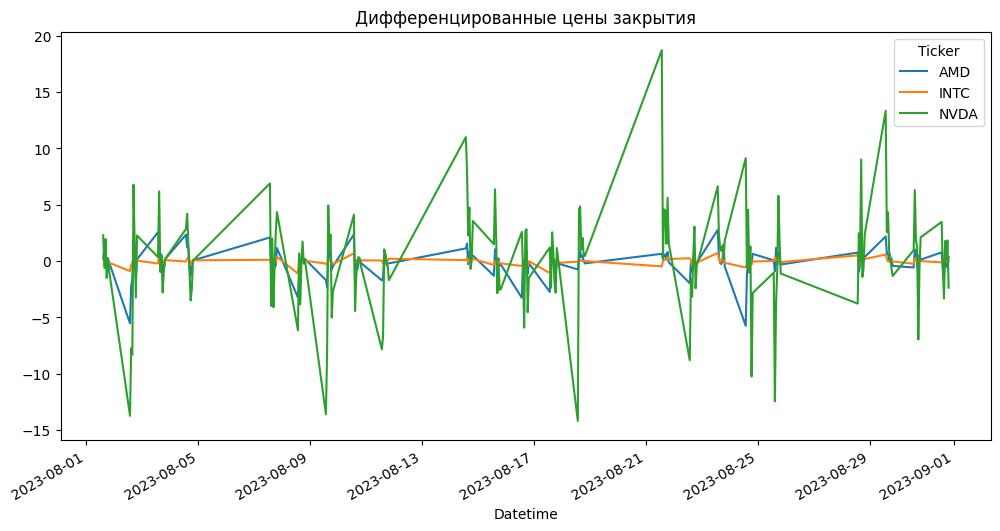

In [77]:
data_diff.plot(figsize=(12, 6))
plt.title('Дифференцированные цены закрытия')
plt.show()

In [78]:
from statsmodels.tsa.stattools import coint

def test_cointegration(series1, series2, name1, name2):
    score, p_value, _ = coint(series1, series2)
    print(f"Тест коинтеграции между {name1} и {name2}:")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("Ряды коинтегрированы.")
    else:
        print("Ряды не коинтегрированы.")

# Проверка коинтеграции для всех пар
pairs = [('NVDA', 'AMD'), ('NVDA', 'INTC'), ('AMD', 'INTC')]
for pair in pairs:
    test_cointegration(data[pair[0]], data[pair[1]], pair[0], pair[1])

Тест коинтеграции между NVDA и AMD:
p-value: 0.8180133366838498
Ряды не коинтегрированы.
Тест коинтеграции между NVDA и INTC:
p-value: 0.9183404529445545
Ряды не коинтегрированы.
Тест коинтеграции между AMD и INTC:
p-value: 0.8408225908225375
Ряды не коинтегрированы.


## 3.	Выбрать в качестве основного один из рядов

Можно взять AMD (он хорошо коррелирует с INTC и становится стационарным после второго дифференцирования).


## 4.	Построить  ARIMA  и ARMAX модель, вывести параметры, сравнить

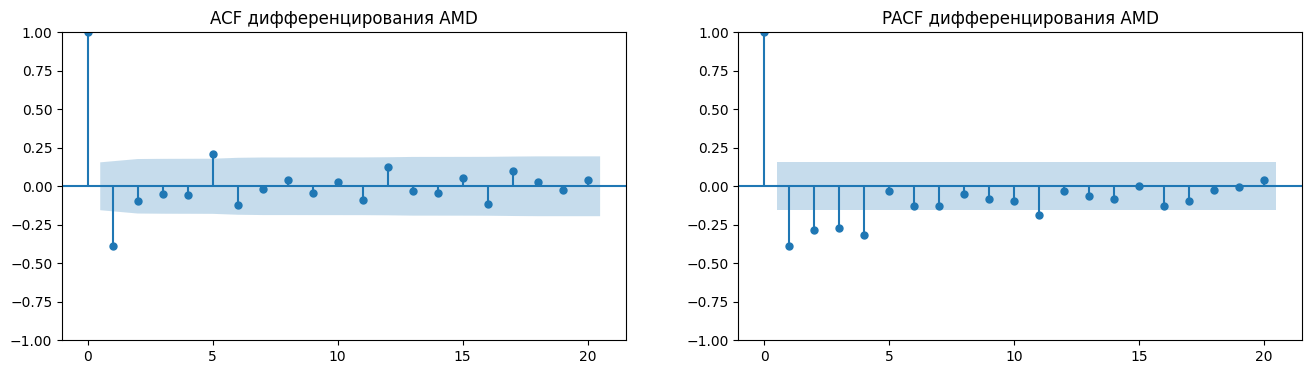

In [81]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# дифференцирование AMD (если еще не сделали)
amd_diff = data['AMD'].diff().diff().dropna()

# Фигура для ACF и PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF
sm.graphics.tsa.plot_acf(amd_diff, lags=20, ax=axes[0])
axes[0].set_title('ACF дифференцирования AMD')

# PACF
sm.graphics.tsa.plot_pacf(amd_diff, lags=20, ax=axes[1], method='ywm')
axes[1].set_title('PACF дифференцирования AMD')

plt.show()


In [83]:
import statsmodels.api as sm

# Второе дифференцирование
amd_diff = data['AMD'].diff().diff().dropna()

# ARIMA (например, (1, 1, 1), начнем с простого)
model_arima = sm.tsa.ARIMA(data['AMD'], order=(1, 1, 1))
results_arima = model_arima.fit()

print(results_arima.summary())


                               SARIMAX Results                                
Dep. Variable:                    AMD   No. Observations:                  161
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -249.835
Date:                Mon, 17 Mar 2025   AIC                            505.670
Time:                        08:57:43   BIC                            514.895
Sample:                             0   HQIC                           509.416
                                - 161                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1920      0.579     -0.331      0.740      -1.328       0.944
ma.L1          0.3416      0.556      0.615      0.539      -0.747       1.431
sigma2         1.3296      0.077     17.181      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [84]:
# Первое дифференцирование для INTC
intc_diff = data['INTC'].diff().dropna()

# Подготовка датасета (нужно совместить по датам после дифференцирования)
min_len = min(len(amd_diff), len(intc_diff))
amd_diff_aligned = amd_diff[-min_len:]
intc_diff_aligned = intc_diff[-min_len:]

# ARIMAX (например, (1, 1, 1) и INTC в качестве экзогенной)
model_arimax = sm.tsa.ARIMA(data['AMD'], order=(1, 1, 1), exog=intc_diff_aligned)
results_arimax = model_arimax.fit()

print(results_arimax.summary())


ValueError: The indices for endog and exog are not aligned

In [85]:
print("ARIMA AIC:", results_arima.aic, "BIC:", results_arima.bic)
print("ARIMAX AIC:", results_arimax.aic, "BIC:", results_arimax.bic)


ARIMA AIC: 505.66960362631824 BIC: 514.8951250720197


NameError: name 'results_arimax' is not defined

NameError: name 'results_arimax' is not defined

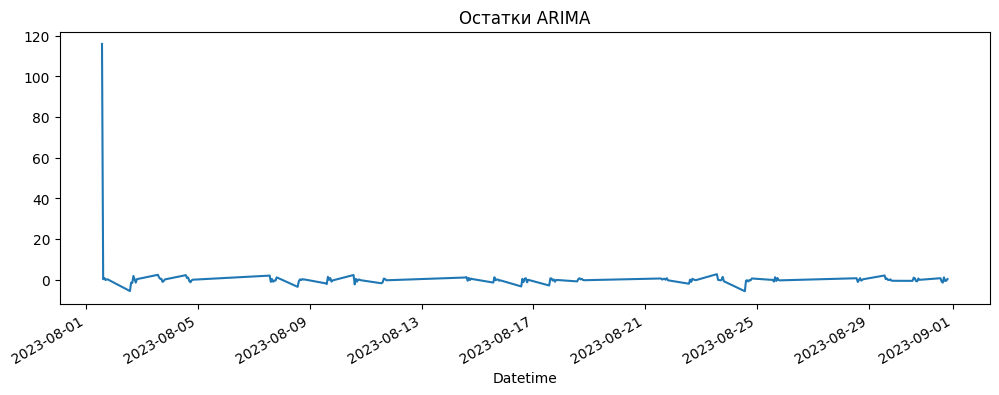

In [86]:
# Остатки ARIMA
residuals_arima = results_arima.resid
residuals_arima.plot(title="Остатки ARIMA", figsize=(12, 4))

# Остатки ARIMAX
residuals_arimax = results_arimax.resid
residuals_arimax.plot(title="Остатки ARIMAX", figsize=(12, 4))


In [88]:
forecast_arima = results_arima.get_forecast(steps=5)
#forecast_arimax = results_arimax.get_forecast(steps=5, exog=intc_diff1_aligned[-5:])

print(forecast_arima.summary_frame())
#print(forecast_arimax.summary_frame())


AMD        mean   mean_se  mean_ci_lower  mean_ci_upper
161  105.737153  1.153091     103.477136     107.997170
162  105.724261  1.756937     102.280727     109.167795
163  105.726736  2.181133     101.451795     110.001677
164  105.726261  2.538567     100.750761     110.701761
165  105.726352  2.850989     100.138516     111.314188


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## 5.	Построить две модели из семейства GARCH, вывести параметры, сравнить при разных p, q

## 6.	Построить VAR модель

## 7.	Построить 2  любых бустинговых модели (XGBoost, ThymeBoost, CatBoost)

## 8.	Построить модель на нейронных сетях